# Homework 16

Section 11.2

Math 404

Winter 2020

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.base import ClusterMixin
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

## Exercise 11.7
Code up the EM algorithm for a Gaussian Mixture model.  Your code should accept a tuple of samples $\mathbf{y}_1, \ldots, \mathbf{y}_n$, a nonnegative integer $K$, and, optionally, an initial guess of the parameters $\theta^0 = (w_1^0,\ldots,w_K^0,\boldsymbol{\mu}_1^0, \ldots, \boldsymbol{\mu}_K^0,\Sigma_1^0, \ldots, \Sigma_K^0)$.
If no initial $\theta^0$ is provided, construct one randomly (Consider choosing the $\boldsymbol{\mu}_k$ from the data $\mathbf{y}_1, \ldots, \mathbf{y}_n$.  What would be good initial choices for $w_k$ and $\Sigma_k$?)

In [2]:
class EM4GMM(ClusterMixin):
    
    def __init__(self, n_components, theta0=None):
        """
        Parameters
        ----------
        n_components -- positive int
            Number of different distributions in the mixture (k)
            
        theta0 -- list (optional)
            theta0[:n_components] contains the weights for each class.
            theta0[n_compoents:1*n_components] contains the means for each class.
            theta0[2*n_componets:3*n_components] contains the variances.
            If theta0 is not provided, it is constructed in the fit() method, when data is given.
        """
        
        self.K = n_components
        
        if theta0 is None:
            self.w = None
            self.mu = None
            self.sigma = None
        else:
            self.w = np.array(theta0[:k])
            self.mu = np.array(theta0[k:2*k])
            self.sigma = np.array(theta0[2*k : 3*k])
        
        return
    
    
    def _initialize_theta0(self, y):
        """
        This function gets called by fit() if theta0 was not specified.
        
        Parameters
        ----------
        y -- ndarray of shape (N,d)
            Each row represents a different observation of the random variable Y.
        """
        n_observations, n_features = y.shape
        self.w = np.random.random(self.K) + .01 #Draw from [.01, 1.01]
        self.mu = np.empty((self.K, n_features))
        self.sigma = np.empty((self.K, n_features, n_features))
        
        #Normalize our weights
        self.w = self.w / self.w.sum()
        #"""
        #Take k random points and make them our means.
        points = np.random.choice(n_observations, self.K)
        self.mu = y[points]
        
        #Take random subsamples and use those to estimate the covariances.
        for k in range(self.K):
            points = np.random.choice(n_observations, n_observations//self.K)
            self.sigma[k] = np.cov(y[points], rowvar=False)

        return

With each iteration and existing estimate $\theta^t$, your code should compute the contributions $r_{ik} = q_i(k)$ for each $i \in \{1, \ldots, K\}$ and the updates $w_k^{t+1}$, $\boldsymbol{\mu}_k^{t+1}$, and $\Sigma_k^{t+1}$.  Include a stopping criterion (including a maximum number of iterations and some measure of how well the estimates are converging).

#### Notes about the code.
I calculate $r_{ik}$ using Bayes' rule.  Let $C_i$ represent the cluster that $X_i$ comes from.
$$
r_{ik} = q_i(k) = P(C_i=k | X_i = x_i, \theta)
\\
= \frac{P(X_i=x_i | C_i = k, \theta) P(C_i = k | \theta)}{\sum_{c=1}^K P(X_i=x_i | C_i = c, \theta) P(C_i = c | \theta)}
\\
= \frac{\mathscr{N}(x_i; \mu_k, \Sigma_k) w_k}{\sum_{c=1}^K \mathscr{N}(x_i; \mu_c, \Sigma_c) w_c}
$$

I use ``np.einsum`` to avoid for loops while calculating $\mu_k^{t+1}$ and $\Sigma_{k}^{t+1}$.
Here's how that works, ignoring their shared denominator.

Let $(\mu_{k}^{t+1})_j$ represent the $j$-th entry of $\mu_{k}^{t+1}$.
$$
(\boldsymbol{\mu}_{k}^{t+1})_j
=
\left(\sum_{i=1}^{n}q_i(k)\mathbf{x}_i\right)_j \quad \text{11.8 (ignoring denominator)}
\\
=
\sum_{i=1}^{n}\Big(q_i(k)\mathbf{x}_i\Big)_j \quad \text{matrix addition is entrywise.}
\\
=
\sum_{i=1}^{n}q_i(k)(\mathbf{x}_i)_j \quad \quad \text{scalar multiplication is entrywise}
$$
I will be using the syntax ``np.einsum('ik,ij->kj', r, y)`` to calculate this.
We can index our array of $r_{i, k} = q_i(k)$ for the probability of the $k$th class at the $i$th observation.
I store observations in rows and classes in columns for $r$, so that's where ``ik`` comes from in the command.
We can index our array of observations $\mathbf{x}$ with $i$ for the observation and $j$ for the entry.
That's where ``"ij"`` comes from in the command.  I store observations in rows and features in columns.
So, we can index our array of mus with $k, j$ for the $j$th-entry and $k$th class mean.  That's where ``kj`` comes from.
Notice that ``i`` is missing after the comma.  ``einsum`` notices that out and sums over i, collapsing it out.

Similarly,
$$
\left(\Sigma^{t+1}_{k}\right)_{j,\ell} 
= \left(\sum_{i=1}^{n}q_i(k)\left(\mathbf{x}_i -\boldsymbol{\mu}_k^{t+1}\right)\left(\mathbf{x}_i -\boldsymbol{\mu}_k^{t+1}\right)^{\intercal}\right)_{j,\ell}\\
= \sum_{i=1}^{n} \left(
    q_i(k)
    \left(\mathbf{x}_i -\boldsymbol{\mu}_k^{t+1}\right)
    \left(\mathbf{x}_i -\boldsymbol{\mu}_k^{t+1}\right)^{\intercal}
    \right)_{j,\ell}
\\
= \sum_{i=1}^{n}
    q_i(k)
    \left(\mathbf{x}_i -\boldsymbol{\mu}_k^{t+1}\right)_{j}
    \left(\mathbf{x}_i -\boldsymbol{\mu}_k^{t+1}\right)_{\ell}
\\
\text{(Remember, outer products involve no sums.)}
$$
If we set $d_{k, i, j} = (\mathbf{x}_i)_{\ell} -(\boldsymbol{\mu}_k^{t+1})_j$ we get
``sigma = np.einsum('ik,kij,kil->kjl', r, d, d)``.  We'll need to insert an extra ``i`` axis into $\mu^{t+1}$ and an extra ``k`` axis into $\mathbf{x}$ to have everything work out right for computing $d$.

In [3]:
class EM4GMM(EM4GMM):
    
    def fit(self, y, maxiters=1000, etol=1e-7, verbose=True):
        """
        Iteratively computes w, mu, and sigma using expectation maximization on the given data (y).
        
        Parameters
        ----------
        y -- ndarray of shape (N,d)
            Each row represents a different observation of the random variable Y.
        
        maxiters -- positive int
            Maximum allowable number of iterative updates of w, mu, and sigma.
        
        etol -- positive int
            When the 2-norm of the change in parameters gets less than etol, the iteration stops.
            
        verbose -- boolean
            Whether or not to print out which iteration we're on.
        """
        if self.w == None:
            self._initialize_theta0(y)
        
        for dummy in range(maxiters):
            
            if verbose:
                print("Iteration", dummy, end='\r')
            
            parameter_change = self._improve_params(y)
            
            if parameter_change < etol:
                return
        
        if verbose:
            print("Maximum number of iterations exceeded!")
        return
        
        
    def _improve_params(self, y):
        """
        Uses expectation maximization to update the parameters of the model.
        
        Parameters
        ----------
        y -- ndarray of shape (N,d)
            Each row represents a different observation of the random variable Y.
            
        Returns
        -------
        parameter_change -- float
            The 2-norm of the change in parameters
        """
        n_obs, n_features = y.shape
        
        old_w = self.w.copy()
        old_mu = self.mu.copy()
        old_sigma = self.sigma.copy()
        
        r = self._calculate_r(y)
        
        #Use equation 11.7 to find w.
        shared_denom = r.sum(axis=0)
        self.w = shared_denom / n_obs
        
        #Use equation 11.8 to update mu and sigma.
        self.mu = np.einsum('ik,ij->kj', r, y)
        self.mu /= shared_denom[:,np.newaxis]
        d = y[np.newaxis,:,:] - self.mu[:,np.newaxis,:]
        self.sigma = np.einsum('ik,kij,kil->kjl', r, d, d) / shared_denom[:,np.newaxis,np.newaxis]
        
        #Find the 2-norm of the change.
        w_change = self.w - old_w
        mu_change = self.mu - old_mu
        sigma_change = self.sigma - old_sigma
        stacked = np.hstack((w_change.ravel(), mu_change.ravel(), sigma_change.ravel()))
        return np.linalg.norm(stacked)
    
    def _calculate_r(self, y):
        """
        Finds the matrix r where R[i,k] = P(C=k | Y=y_i, Theta)
        
        Parameters
        ----------
        y -- ndarray of shape (N,d)
            Each row represents a different observation of the random variable Y.
        """
        n_obs, n_features = y.shape
        
        normal_pdf_values = np.empty((n_obs, self.K))
        for k, (mu, sigma) in enumerate(zip(self.mu, self.sigma)):
            normal_pdf_values[:,k] = stats.multivariate_normal.pdf(y, mean=mu, cov=sigma)
        numerator = normal_pdf_values * self.w
        denominator = numerator.sum(axis=1, keepdims=True)
        r = numerator / denominator
        return r

## Exercise 11.8
Use your GMM EM code to construct a clustering algorithm as follows:
For a collection of data $\mathbf{x}_1, \ldots, \mathbf{x}_n$ and a choice of $K$,
use the EM algorithm to estimate $\hat{\theta}$ and the p.d.f.s $f_k(\mathbf{x}) = \mathscr{N}(\mathbf{x}; \boldsymbol{\mu}_k, \Sigma_k)$ of the individual Gaussians.  Assign each $\mathbf{x}_i$ to the cluster $k$ that has the greates likelihood ($\text{argmax}_k f_k(\mathbf{x}_i)$).

In [4]:
class EM4GMM(EM4GMM):
    
    def transform(self, y):
        """
        Assigns each row of y to the cluster it most likely belongs to.
        
        Parameters
        ----------
        y -- ndarray of shape (N,d)
            Each row represents a different observation of the random variable Y.
        """
        #Make an array that holds probabilities. r[i,k] = P(C=k|Y=y_i)
        r = self._calculate_r(y)
        #Choose the argmax for each observation.
        return r.argmax(axis=1)

### Part (i)
Apply your code to the iris dataset with $K=3$ and evaluate how well it did at separating the three species of iris.

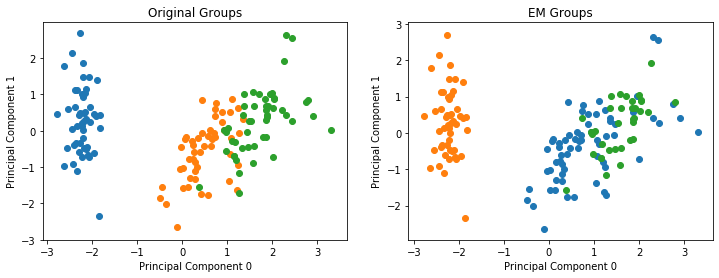

In [5]:
#Run the clustering algorithm on the raw data.
X, y_natural = load_iris(return_X_y=True)
my_cluster = EM4GMM(3)
my_cluster.fit(X)
y_generated = my_cluster.transform(X)

#Use PCA on the data so we can graph it easily.
sk_PCA = PCA(n_components=2)
X_scaled = (X - X.mean(axis=0))/X.std(axis=0)
X_pca = sk_PCA.fit_transform(X_scaled)

#Plot one vs other.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for ax, y, name in zip(axes.ravel(), [y_natural, y_generated], ['Original', 'EM']):
    for label in range(3):
        cluster = X_pca[y==label]
        ax.scatter(cluster[:,0], cluster[:,1])
    ax.set_title("{} Groups".format(name))
    ax.set_xlabel("Principal Component 0")
    ax.set_ylabel("Principal Component 1")

plt.show()

It does a great job at separating the setosa species, but has a hard time separating viriginica from versicolor.

### Part (ii)
Apply your code to answer a clustering question about your project dataset (or another large dataset that interests you).  Experiment with different values of $K$.  Interpret and evaluate the results.

In [6]:
#When a student signs up, we get 3 easy features:
#1) What time of day they signed up.
#2) How long they waited.
#3) How long they were helped for.
# Let's see what happens when we group into 2.  Do we get upper vs lower, or something else?
from lsv3dp.clean.signUp import mergeHandEnteredAndElectronic
df = mergeHandEnteredAndElectronic()
df.head(4)

c:\users\math tutor\desktop\acme data project\src\lsv3dp\clean\signUp.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat((el, he))


Unnamed: 0 chapter chapterSection classSection    course      date  \
0         NaN     NaN            1.1            7  MATH 313  9/6/2018   
1         NaN     NaN            1.1           11  MATH 313  9/6/2018   
2         NaN     NaN           12.1            1  MATH 314  9/6/2018   
3         NaN     NaN           12.1            3  MATH 314  9/6/2018   

  helpDoneDate helpDoneTime helpDuration helpStartDate helpStartTime  \
0     9/6/2018     10:01:22          NaT          NULL          NULL   
1     9/6/2018     10:39:06          NaT          NULL          NULL   
2     9/6/2018     10:44:45          NaT          NULL          NULL   
3     9/6/2018     13:17:29          NaT          NULL          NULL   

  instructor problem section signUpTime tutorInitials  tutorName  \
0        NaN      28     NaN    9:36:32          None  NULL NULL   
1        NaN      14     NaN   10:16:07          None  NULL NULL   
2        NaN     NaN     NaN   10:32:53          None  NULL NULL   
3        NaN      40     NaN   13:11:19          None  NULL NULL   

             whyDone  
0  Student Cancelled  
1  Student Cancelled  
2  Student Cancelled  
3  Student Cancelled

In [7]:
tdf = df.drop(columns=['chapter', 'chapterSection', 'classSection', 'helpStartDate', 'instructor', 'problem', 'section',
                      'helpDoneDate', 'whyDone', 'tutorName', 'tutorInitials', 'Unnamed: 0'])
tdf.head(5)

course      date helpDoneTime helpDuration helpStartTime signUpTime
0  MATH 313  9/6/2018     10:01:22          NaT          NULL    9:36:32
1  MATH 313  9/6/2018     10:39:06          NaT          NULL   10:16:07
2  MATH 314  9/6/2018     10:44:45          NaT          NULL   10:32:53
3  MATH 314  9/6/2018     13:17:29          NaT          NULL   13:11:19
4  MATH 334  9/6/2018     13:57:21          NaT          NULL   13:42:17

In [8]:
tdf.course = tdf.course.str.replace("MATH ", "")
tdf.date = pd.to_datetime(tdf.date, errors='coerce')
tdf.helpDoneTime = pd.to_timedelta(tdf.helpDoneTime, errors='coerce')
tdf.helpStartTime = pd.to_timedelta(tdf.helpStartTime, errors='coerce')
tdf.signUpTime = pd.to_timedelta(tdf.signUpTime, errors='coerce')
tdf.helpDuration = pd.to_timedelta(tdf.helpDuration, errors='coerce')
tdf['waitTime'] = tdf.helpStartTime - tdf.signUpTime
tdf.drop(columns=['helpDoneTime', 'helpStartTime'], inplace=True)
tdf.dropna(inplace=True)
tdf.head(5)

course       date helpDuration signUpTime waitTime
585    313 2018-10-03     00:01:49   13:21:40 00:00:34
586    313 2018-10-03     00:07:02   13:25:18 00:00:27
587    313 2018-09-28     00:06:18   13:43:28 00:02:44
588    313 2018-10-24     00:05:28   13:09:12 00:01:56
589    302 2018-10-24     00:10:56   14:53:01 00:05:44

In [9]:
tdf.dtypes

course                   object
date             datetime64[ns]
helpDuration    timedelta64[ns]
signUpTime      timedelta64[ns]
waitTime        timedelta64[ns]
dtype: object

In [10]:
my_EM4GMM = EM4GMM(2)
X = tdf[['helpDuration', 'signUpTime', 'waitTime']]
X_scaled = (X - X.mean(axis=0))/X.std(axis=0)
X_scaled[abs(X_scaled) > 7] = None
X_scaled.dropna(inplace=True)
my_EM4GMM.fit(X_scaled.values)
y = my_HM4GMM.transform(X_scaled.values)
print(y.summary())

LinAlgError: singular matrix

In [ ]:
#Ok, I just straight up haven't been able to get this to do anything for like an hour.
#I need to go home and go to bed.
#Before I go, I guess we could try to do this with more clusters, just to see if it doesn't get a singular matrix.

In [11]:
my_EM4GMM = EM4GMM(7)
X = tdf[['helpDuration', 'signUpTime', 'waitTime']]
X_scaled = (X - X.mean(axis=0))/X.std(axis=0)
X_scaled[abs(X_scaled) > 7] = None
X_scaled.dropna(inplace=True)
my_EM4GMM.fit(X_scaled.values)
y = my_HM4GMM.transform(X_scaled.values)
print(y.summary())

LinAlgError: singular matrix

In [ ]:
#Yeah.  Around 4 or 6 iterations in it always hits a singular matrix.  Don't know what to do here.